In [1]:
import networkx as nx
import pandas as pd
from joblib import Parallel, delayed
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import numpy as np

In [2]:
############################
# RELEVANT ISO CODES
############################

hs_codes = [
    
    ############################
    # Gold -> Baseline
    ############################
    710812,
    
    ############################
    # Medicine and Antibiotics -> Baseline
    ############################
    300490, 294190,
    
    ############################
    # Aluminium
    ############################
    760110,
    
    ############################
    # Energy: Oil and Coal
    ############################
    270900, 270112,
    
    ############################
    # Semiconductors
    ############################
    853400
]

In [3]:
def merge_country_and_product_names(dataframe, country_codes, product_codes, export_col="i", import_col="j", product_col="k", hs_codes=hs_codes):
    """
    Merge country names and product descriptions into a dataframe based on country and product codes.

    Parameters:
    dataframe (pd.DataFrame): The main dataframe containing country and product codes.
    country_mapping (pd.DataFrame): A dataframe containing `country_code` and `country_name`.
    product_codes (pd.DataFrame): A dataframe containing `code` and `product_description`.
    export_col (str): The column in `dataframe` representing export country codes. Default is 'i'.
    import_col (str): The column in `dataframe` representing import country codes. Default is 'j'.
    product_col (str): The column in `dataframe` representing product codes. Default is 'k'.

    Returns:
    pd.DataFrame: A dataframe with `export_country`, `import_country`, and `product_description` columns added.
    """
    #####################
    # RELEVANT CARGOES
    #####################
    dataframe = dataframe[dataframe.k.isin(hs_codes)]
    
    #####################
    # COUNTRY NAMES
    #####################
    df = pd.merge(
        left=dataframe,
        right=country_codes[["country_code", "country_name"]],
        left_on=export_col,
        right_on="country_code",
        how="left"
    ).rename(columns={"country_name": "export_country"}).drop(columns=["country_code"], axis=1)

    df = pd.merge(
        left=df,
        right=country_codes[["country_code", "country_name"]],
        left_on=import_col,
        right_on="country_code",
        how="left"
    ).rename(columns={"country_name": "import_country"}).drop(columns=["country_code"], axis=1)
    
    #####################
    # PRODUCT DESCRIPTION
    #####################
    df = pd.merge(
        left=df,
        right=product_codes[["code", "description"]],
        left_on=product_col,
        right_on="code",
        how="left"
    ).drop(columns=["code"], axis=1)

    return df


In [4]:
def process_file(file):
    """
    Process a given CSV file to prepare it for analysis.

    This function reads a CSV file from the 'dataset' directory, merges it with
    country and product codes, and extracts the year from the filename.

    Args:
        file (str): The name of the file to process (e.g., 'data_Y2022.csv').

    Returns:
        tuple: A tuple containing:
            - year (str): The year extracted from the filename.
            - df (pd.DataFrame): A pandas DataFrame containing the processed data.
        If the filename does not contain a valid year, returns (None, None).
    """
    file_path = os.path.join(os.getcwd(), "dataset", file)
    df = pd.read_csv(file_path, low_memory=False)
    df = merge_country_and_product_names(df, country_codes, product_codes)
    
    try:
        year = file.split("_Y")[1][:4]
    except IndexError:
        print(f"Filename {file} does not contain a valid year.")
        return None, None
    
    return year, df

def pivot_trade_data(dataframe, trade_type='export'):
    """
    Create a pivot table from trade data for either exports or imports.

    This function pivots the input DataFrame to summarize trade quantities
    ('q') by trade time ('t') for the specified trade type.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing trade data. 
            Must include the following columns: ['export_country', 'import_country', 'k', 
            'description', 't', 'q'].
        trade_type (str, optional): The type of trade to pivot on. Must be either
            'export' or 'import'. Defaults to 'export'.

    Returns:
        pd.DataFrame: A pivoted DataFrame with trade summaries.
        If an invalid `trade_type` is provided, returns None.
    """
    if trade_type == 'export':
        pivot_df = dataframe.pivot_table(
            index=['export_country', 'import_country', 'k', 'description'],
            columns='t',
            values='q',
            aggfunc='sum',
            fill_value=0
        )
    elif trade_type == 'import':
        pivot_df = dataframe.pivot_table(
            index=['import_country', 'export_country', 'k', 'description'],
            columns='t',
            values='q',
            aggfunc='sum',
            fill_value=0
        )
    else:
        print("Invalid trade_type. Use 'export' or 'import'.")
        return None

    pivot_df.reset_index(inplace=True)

    return pivot_df


In [5]:
#####################
# Preprocessing
#####################
if os.path.exists(os.path.join("basedata", "base_data.csv")):
    print("Loading precomputed file")
    df = pd.read_csv(os.path.join(os.getcwd(), "basedata", "base_data.csv"), low_memory=False)
    
else:
    files_to_process = [
        file for file in os.listdir(os.path.join(os.getcwd(), "dataset"))
        if file.startswith("BACI_") and file.endswith(".csv")
    ]
    
    print(files_to_process)
    
    country_codes = pd.read_csv(os.path.join("dataset", "country_codes_V202401b.csv"))
    product_codes = pd.read_csv(os.path.join("dataset", "product_codes_HS22_V202401b.csv"))
    
    results = Parallel(n_jobs=-1, backend='loky')(delayed(process_file)(file) for file in files_to_process)
    processed_files = {year: df for year, df in results if year is not None and df is not None}
    
    df = pd.concat([d for d in processed_files.values()], axis=0, ignore_index=True)
    
    
    #####################
    # TYPE CASTING
    #####################
    df['export_country'] = df['export_country'].astype(str)
    df['import_country'] = df['import_country'].astype(str)
    df['k'] = df['k'].astype(int)
    df['t'] = df['t'].astype(int)
    df['q'] = pd.to_numeric(df['q'], errors="coerce")
    
    
    ##################
    # GEOCODING
    ##################
    geolocator = Nominatim(user_agent="geoapi")
    
    rename_dict = {
        'Solomon Isds': 'Solomon Islands',
        'Br. Virgin Isds': 'British Virgin Islands',
        'Cayman Isds': 'Cayman Islands',
        'Central African Rep.': 'Central African Republic',
        'Christmas Isds': 'Christmas Island',
        'Cocos Isds': 'Cocos (Keeling) Islands',
        'Dem. Rep. of the Congo': 'Democratic Republic of the Congo',
        'Cook Isds': 'Cook Islands',
        'Dominican Rep.': 'Dominican Republic',
        'Falkland Isds (Malvinas)': 'Falkland Islands (Islas Malvinas)',
        'Fr. South Antarctic Terr.': 'French Southern and Antarctic Lands',
        "Dem. People's Rep. of Korea": 'North Korea',
        'Rep. of Korea': 'South Korea',
        "Lao People's Dem. Rep.": 'Laos',
        'China, Macao SAR': 'Macau',
        'Rep. of Moldova': 'Moldova',
        'N. Mariana Isds': 'Northern Mariana Islands',
        'Turks and Caicos Isds': 'Turks and Caicos Islands',
        'United Rep. of Tanzania': 'Tanzania',
        'Wallis and Futuna Isds': 'Wallis and Futuna',
        'Br. Indian Ocean Terr.': 'British Indian Ocean Territory',
        'Mayotte (Overseas France)': 'Mayotte',
        'FS Micronesia': 'Federated States of Micronesia',
        'Marshall Isds': 'Marshall Islands',
        'Norfolk Isds': 'Norfolk Island'
    }
    
    geocodings = []
    
    for country in set(df.export_country.unique().tolist() + df.import_country.unique().tolist()):  
        location = geolocator.geocode(country)
        
        try:    
            lat, long = location.latitude, location.longitude
        
        except Exception as e:
            renamed_country = rename_dict.get(country, None)
            
            if not renamed_country is None:
                location = geolocator.geocode(renamed_country)
                lat, long = location.latitude, location.longitude
            
            else:
                print(f"Geocoding failed for {country}")
                continue
        
        geocodings.append((country, lat, long))
        
    geocodings_df = pd.DataFrame(geocodings, columns=['country', 'latitude', 'longitude'])

    df = pd.merge(left=df, right=geocodings_df, left_on="import_country", right_on="country", how="left").rename(
    columns={"latitude": "import_latitude", "longitude": "import_longitude"}).drop(
    columns=["country"], axis=1
    )
    
    df = pd.merge(left=df, right=geocodings_df, left_on="export_country", right_on="country", how="left").rename(
        columns={"latitude": "export_latitude", "longitude": "export_longitude"}).drop(
        columns=["country"], axis=1
    )
    
    df['distance_km'] = df.apply(
        lambda row: geodesic((row.import_latitude, row.import_longitude), (row.export_latitude, row.export_longitude)).kilometers if not pd.isna(row.export_latitude) and not pd.isna(row.import_latitude) else np.nan, axis=1
    )

    #####################
    # GRAVITY DATASET
    #####################
    gravity = pd.read_csv(os.path.join("gravity", "Gravity_V202211.csv"), low_memory=False)
    
    # Drop Duplicates based on number of nan values
    gravity["nan_count"] = gravity.isna().sum(axis=1)
    gravity = gravity.sort_values(by=["iso3_o", "iso3_d", "year", "nan_count"])
    gravity = gravity.drop_duplicates(subset=["iso3_o", "iso3_d", "year"], keep="first")
    gravity = gravity.drop(columns=["nan_count"])
    
    country_codes = pd.read_csv(os.path.join("dataset", "country_codes_V202401b.csv"))
    
    gravity = pd.merge(left=gravity, right=country_codes[["country_name", "country_iso3"]], left_on="iso3_o", right_on="country_iso3", how="left").rename(
        columns={"country_name": "country_o"}).drop(
        columns=["country_iso3"], axis=1
    )
    
    gravity = pd.merge(left=gravity, right=country_codes[["country_name", "country_iso3"]], left_on="iso3_d", right_on="country_iso3", how="left").rename(
        columns={"country_name": "country_d"}).drop(
        columns=["country_iso3", "country_id_o", "country_id_d", "iso3_o", "iso3_d", "iso3num_o", "iso3num_d"], axis=1
    )
    
    df = pd.merge(left=df, right=gravity, left_on=["t", "export_country", "import_country"], right_on=["year", "country_o", "country_d"], how="left")
    
        
pivot_df_import = pivot_trade_data(df, trade_type="import")
pivot_df_export = pivot_trade_data(df, trade_type="export")

Loading precomputed file


In [6]:
# :(

len(df[df.q.isna()])

20653

In [7]:
#####################
# GRAPH CONSTRUCTION
#####################
product_graphs = {code: nx.MultiDiGraph() for code in hs_codes}

for idx, row in df.iterrows():
    exporter = row['export_country']
    importer = row['import_country']
    product_code = row['k']
    year = row['t']
    quantity = row['q']

    G = product_graphs[product_code]

    G.add_node(exporter)
    G.add_node(importer)

    edge_key = (exporter, importer, year)

    G.add_edge(
        exporter,
        importer,
        key=edge_key,
        year=year,
        quantity=quantity
    )


In [8]:
#####################
# VISUALIZER
#####################
class TradeNetworkVisualizer:
    def __init__(self, product_graphs, dataframe):
        self.product_graphs = product_graphs
        self.dataframe = dataframe


    def visualize_product_graph(self, product_code, year): 
        """
        Visualize the trade network graph for a specific product and year.
    
        This method extracts the edges corresponding to the given year from a product-specific
        graph and visualizes the resulting trade network. If no data is available for the given
        product or year, it prints a corresponding message.
    
        Args:
            product_code (str): The code identifying the product whose trade network graph 
                is to be visualized.
            year (int): The year for which the trade network is to be displayed.
    
        Returns:
            None: Displays the trade network graph or prints an informational message 
            if no data is available.
    
        Raises:
            None: This method does not raise exceptions but handles errors gracefully by 
            printing messages in cases where the graph or data for the specified year is missing.
    
        Notes:
            - The graph is assumed to be a `networkx.MultiDiGraph` object stored in 
              `self.product_graphs` with edges containing a 'year' attribute.
            - Nodes represent countries or entities, while edges represent trade relationships.
            - The layout is generated using a spring layout with `networkx`.
    
        Visualization Details:
            - Nodes are displayed as blue circles with a size of 50.
            - Edges are directed and represented with arrows.
            - The graph is drawn using Matplotlib with a fixed figure size of (20, 20).
        """
        
        G = self.product_graphs.get(product_code)
        if G is None:
            print(f"No graph found for product code {product_code}.")
            return

        edges_in_year = [
            (u, v, k) for u, v, k, data in G.edges(data=True, keys=True)
            if data['year'] == year
        ]

        G_year = nx.MultiDiGraph()
        G_year.add_nodes_from(G.nodes(data=True))
        G_year.add_edges_from((u, v, k, G.get_edge_data(u, v, k)) for u, v, k in edges_in_year)

        if G_year.number_of_edges() == 0:
            print(f"No trade data for product {product_code} in year {year}.")
            return

        plt.figure(figsize=(20, 20))
        pos = nx.spring_layout(G_year, k=0.5)

        nx.draw_networkx_nodes(G_year, pos, node_size=50, node_color='skyblue')
        nx.draw_networkx_edges(G_year, pos, arrowstyle='->', arrowsize=10)
        nx.draw_networkx_labels(G_year, pos, font_size=8)
        
        product_title = self.dataframe[self.dataframe.k == product_code].description.unique()[0]
    
        plt.title(f'Trade Network for {product_title} in {year}')
        plt.axis('off')
        plt.show()


    def plot_trade_network(self, product_code, country_name, trade_type='export', figsize=(20, 15), export_to_png=False, export_file_name="", percentile=1.0):
        """
        Plots a trade network graph for a specific product code and either an export or import country.
    
        Nodes are weighted according to the share of total trade volume with the specified country.
        Edges represent trade relationships, weighted by trade volume.
    
        Optionally, you can display only a specific percentile of trades based on trade volume.
        For example, setting `percentile=0.5` will display only the largest 50% of all trades.
    
        Parameters:
            product_code (str): The product code for which the trade network is to be plotted.
            country_name (str): The name of the country (exporting or importing) to focus on.
            trade_type (str, optional): 'export' to plot exports from the country, 'import' for imports into the country.
                                        Defaults to 'export'.
            figsize (tuple, optional): Figure size for the plot. Defaults to (20, 15).
            export_to_png (bool, optional): If True, exports the plot to a PNG file. Defaults to False.
            export_file_name (str, optional): Filename for the exported PNG. If not provided, a default name is generated.
            percentile (float, optional): A value between 0 and 1 indicating the percentile of trades to display.
                                          For example, 0.5 displays only the largest 50% of trades by volume.
                                          Defaults to 1.0 (displays all trades).
    
        Returns:
            None
    
        Displays a plot of the trade network or exports it to a PNG file if `export_to_png` is True.
    
        Notes:
            - The function filters and aggregates trade data based on the provided `product_code` and `country_name`.
            - Node sizes represent the trade volume share with the main country.
            - Edge widths are proportional to the trade volume.
            - If `percentile` is less than 1.0, only the largest trades (by volume) up to that percentile are displayed.
            - This can be useful for focusing on the most significant trade relationships.
    
        Example:
            To plot the largest 50% of export trades for product 'P123' from 'CountryA':
    
            ```python
            plot_trade_network('P123', 'CountryA', trade_type='export', percentile=0.5)
            ```
        """
        dataframe = self.dataframe
    
        if trade_type == 'export':
            filtered_data = dataframe[(dataframe.k == product_code) & (dataframe.export_country == country_name)]
        elif trade_type == 'import':
            filtered_data = dataframe[(dataframe.k == product_code) & (dataframe.import_country == country_name)]
        else:
            print("Invalid trade_type. Use 'export' or 'import'.")
            return
    
        if filtered_data.empty:
            print(f"No trade data found for product {product_code} and country {country_name}.")
            return
    
        total_volume = filtered_data['v'].sum()
    
        if total_volume == 0:
            print(f"No trade data found for product {product_code} and country {country_name}.")
            return
    
        filtered_data = filtered_data.sort_values(by='v', ascending=False)
    
        filtered_data['cumulative_v'] = filtered_data['v'].cumsum()
        filtered_data['cumulative_percentage'] = filtered_data['cumulative_v'] / total_volume
    
        if percentile < 1.0:
            filtered_data = filtered_data[filtered_data['cumulative_percentage'] <= percentile]
            if filtered_data.empty:
                print(f"No trade data found within the top {percentile*100}% for product {product_code} and country {country_name}.")
                return
    
        total_volume_filtered = filtered_data['v'].sum()
    
        if trade_type == 'export':
            volume_by_country = filtered_data.groupby('import_country')['v'].sum()
        elif trade_type == 'import':
            volume_by_country = filtered_data.groupby('export_country')['v'].sum()
    
        volume_by_country_share = (volume_by_country / total_volume_filtered).to_dict()
    
        G = nx.DiGraph()
    
        for _, row in filtered_data.iterrows():
            G.add_edge(row['export_country'], row['import_country'], weight=row['v'])
    
        node_sizes = {}
        node_colors = {}
    
        main_country_color = 'gold'
        main_country_size = 2000
    
        partner_node_sizes = []
    
        for node in G.nodes():
            if node == country_name:
                node_sizes[node] = main_country_size
                node_colors[node] = main_country_color
            else:
                share = volume_by_country_share.get(node, 0)
                size = 1000 * share + 300
                node_sizes[node] = size
                partner_node_sizes.append(size)
                node_colors[node] = None
    
        if partner_node_sizes:
            cmap = cm.get_cmap('coolwarm')
            norm = mcolors.Normalize(vmin=min(partner_node_sizes), vmax=max(partner_node_sizes))
    
            for node in G.nodes():
                if node != country_name:
                    node_colors[node] = cmap(norm(node_sizes[node]))
        else:
            for node in G.nodes():
                if node != country_name:
                    node_colors[node] = 'lightblue'
    
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        if edge_weights:
            max_weight = max(edge_weights)
            edge_widths = [5 * (w / max_weight) for w in edge_weights]
        else:
            edge_widths = []
    
        plt.figure(figsize=figsize)
        pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
        nx.draw_networkx_nodes(
            G, pos,
            node_size=[node_sizes[node] for node in G.nodes()],
            node_color=[node_colors[node] for node in G.nodes()],
            alpha=0.9
        )
    
        nx.draw_networkx_edges(
            G, pos, arrowstyle="->", arrowsize=15, edge_color="gray",
            width=edge_widths, alpha=0.7
        )
    
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    
        def format_volume(volume):
            if volume >= 1e9:
                return f'{volume / 1e9:.2f}B'
            elif volume >= 1e6:
                return f'{volume / 1e6:.2f}M'
            elif volume >= 1e3:
                return f'{volume / 1e3:.2f}K'
            else:
                return f'{volume}'
    
        edge_labels = {
            (u, v): format_volume(G[u][v]['weight']) for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
        
        product_title = filtered_data.description.unique()[0]
        
        title_trade = "Exporting from" if trade_type == 'export' else "Importing into"
        plt.title(
            f"Trade Network for {product_title} - {title_trade} {country_name}",
            fontsize=15,
            fontweight="bold"
        )
    
        if export_to_png:
            if not export_file_name:
                export_file_name = f"trade_network_{product_code}_{country_name}_{trade_type}.png"
            plt.savefig(export_file_name, bbox_inches='tight')
            plt.close()
        else:
            plt.axis('off')
            plt.show()


    def plot_trade_over_time(self, product_code, country_name, trade_type='export', figsize=(16, 8)):
        """
        Plots the trade volume over time for a specific product code and country.
    
        The plot includes:
        - The country's trade volume over time.
        - The total global trade volume for the product over time.
        - The country's relative share of the total trade volume over time.
    
        Args:
            product_code (str): The product code for which the trade volume is to be plotted.
            country_name (str): The name of the country to focus on (exporting or importing).
            trade_type (str, optional): 'export' to show exports from the country, 
                                        'import' to show imports into the country. Defaults to 'export'.
            figsize (tuple, optional): Size of the plot. Defaults to (12, 6).
    
        Returns:
            None: Displays a line plot of the trade volume over time and the relative share over time.
    
        Notes:
            - Filters the dataset to include only rows for the specified product code and trade type.
            - Computes the country's trade volume over time.
            - Computes the total global trade volume for the product over time.
            - Calculates the country's relative share of the total trade volume over time.
            - Displays a plot with two y-axes:
                - Left y-axis: Trade volumes (country and total).
                - Right y-axis: Relative share (%).
            - Includes a legend to differentiate between the data series.
        """
        dataframe = self.dataframe
    
        product_data = dataframe[dataframe['k'] == product_code]
    
        if product_data.empty:
            print(f"No trade data found for product {product_code}.")
            return
    
        total_trade_volume_over_time = product_data.groupby('t')['v'].sum().reset_index()
    
        if trade_type == 'export':
            country_data = product_data[product_data['export_country'] == country_name]
            
        elif trade_type == 'import':
            country_data = product_data[product_data['import_country'] == country_name]
            
        else:
            print("Invalid trade_type. Use 'export' or 'import'.")
            return
    
        if country_data.empty:
            print(f"No trade data found for product {product_code} and country {country_name}.")
            return
    
        country_trade_volume_over_time = country_data.groupby('t')['v'].sum().reset_index()
    
        merged_data = pd.merge(
            country_trade_volume_over_time, 
            total_trade_volume_over_time, 
            on='t', 
            how='right', 
            suffixes=('_country', '_total')
        )
    
        merged_data['v_country'] = merged_data['v_country'].fillna(0)
        merged_data['relative_share'] = (merged_data['v_country'] / merged_data['v_total']) * 100
        merged_data.sort_values('t', inplace=True)
    
        fig, ax1 = plt.subplots(figsize=figsize)
    
        ax1.plot(
            merged_data['t'], 
            merged_data['v_country'], 
            marker='o', 
            label=f"{country_name} Trade Volume", 
            color='tab:blue'
        )
        
        ax1.plot(
            merged_data['t'], 
            merged_data['v_total'], 
            marker='s', 
            label="Total Trade Volume", 
            color='tab:green'
        )
        
        ax1.set_xticks(merged_data['t'])
        ax1.set_xticklabels(merged_data['t'].astype(int))
        
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Trade Volume (log)')
        ax1.tick_params(axis='y')
        ax1.grid(True)
        ax1.set_yscale("log")
    
        ax2 = ax1.twinx()
        ax2.plot(
            merged_data['t'], 
            merged_data['relative_share'], 
            marker='^', 
            label=f"{country_name} Relative Share (%)", 
            color='tab:red'
        )
        ax2.set_ylabel('Relative Share (%)')
        ax2.tick_params(axis='y', labelcolor='tab:red')
    
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        
        product_title = dataframe[dataframe.k == product_code].description.unique()[0]
        
        plt.title(f"{product_title}\n{trade_type.title()} by {country_name}", fontweight="bold")
        plt.show()
        
        
    def plot_trade_treemap(self, product_code, year, trade_type='export', top_n=None, show_volumes=True, color_scale='Viridis'):
        """
        Plots a treemap of trade volumes for a specific product code and year.
    
        This visualization helps analyze the trade relationships between countries for a given product,
        highlighting the proportion of trade volumes in a hierarchical, space-filling manner.
    
        Args:
            product_code (str): The product code for which the trade volumes are to be plotted.
            year (int): The year for which the trade data is to be visualized.
            trade_type (str, optional): 'export' to visualize exports from countries,
                                        'import' to visualize imports into countries. Defaults to 'export'.
            top_n (int, optional): The number of top country pairs by trade volume to display.
                                   If None, includes all country pairs. Defaults to None.
            show_volumes (bool, optional): If True, displays trade volumes on the treemap labels. Defaults to True.
            color_scale (str, optional): The color scale to use for the treemap (e.g., 'Viridis', 'Cividis', 'Plasma'). Defaults to 'Viridis'.
    
        Returns:
            None: Displays an interactive treemap of trade volumes with a dark background.
    
        Notes:
            - **Data Filtering**: The dataset is filtered based on the provided product code and year.
            - **Grouping**: Trade volumes are aggregated by export/import country pairs.
            - **Top N Filtering**: If `top_n` is specified, only the top N country pairs by trade volume are displayed.
            - **Color Scale Recalculation**: The color scale is automatically recalculated based on the filtered data.
            - **Visualization**:
                - Uses Plotly Express for interactive treemap visualization.
                - Applies a dark theme (`'plotly_dark'`) for better visual appeal.
                - Trade volumes are used both for sizing and coloring the rectangles.
                - Hover information includes formatted trade volumes.
            - **Customization**: Users can customize the color scale, adjust the plot size, and choose whether to display trade volumes on labels.
            - **Search Functionality**: Allows users to highlight a specific country in the treemap.
    
        Example:
            To plot an export treemap for product code 'P123' in year 2022, displaying the top 10 country pairs:
    
            ```python
            plot_trade_treemap('P123', 2022, trade_type='export', top_n=10)
            ```
        """
        dataframe = self.dataframe
    
        if trade_type == 'export':
            df_filtered = dataframe[(dataframe['k'] == product_code) & (dataframe['t'] == year)]
            df_grouped = df_filtered.groupby(['export_country', 'import_country'])['v'].sum().reset_index()
            path = ['export_country', 'import_country']
            
        elif trade_type == 'import':
            df_filtered = dataframe[(dataframe['k'] == product_code) & (dataframe['t'] == year)]
            df_grouped = df_filtered.groupby(['import_country', 'export_country'])['v'].sum().reset_index()
            path = ['import_country', 'export_country']
            
        else:
            return
    
        if df_grouped.empty:
            return
    
        if top_n is not None:
            df_grouped = df_grouped.nlargest(top_n, 'v')
    
        product_title = df_filtered['description'].unique()[0]
    
        fig = px.treemap(
            df_grouped,
            path=path,
            values='v',
            color='v',
            color_continuous_scale=color_scale,
            title=f'Trade Volume Treemap for "{product_title}" in {year} ({trade_type.title()})',
            labels={'v': 'Trade Volume'},
            hover_data={'v': ':,.2f'},
        )
    
        fig.update_layout(
            template='plotly_dark',
            margin=dict(t=50, l=25, r=25, b=25),
            height=800
        )
    
        if show_volumes:
            fig.data[0].textinfo = 'label+value+percent root'
            fig.data[0].texttemplate = '<b>%{label}</b><br>Trade Volume: %{value:,.2f}<br>%{percentRoot:.2%} of Total Volume'
            
        else:
            fig.data[0].textinfo = 'label+percent root'
            fig.data[0].texttemplate = '<b>%{label}</b><br>%{percentRoot:.2%} of Total Volume'
    
        fig.update_coloraxes(colorbar_title='Trade Volume')
    
        fig.show()

In [9]:
visualizer = TradeNetworkVisualizer(product_graphs, df)

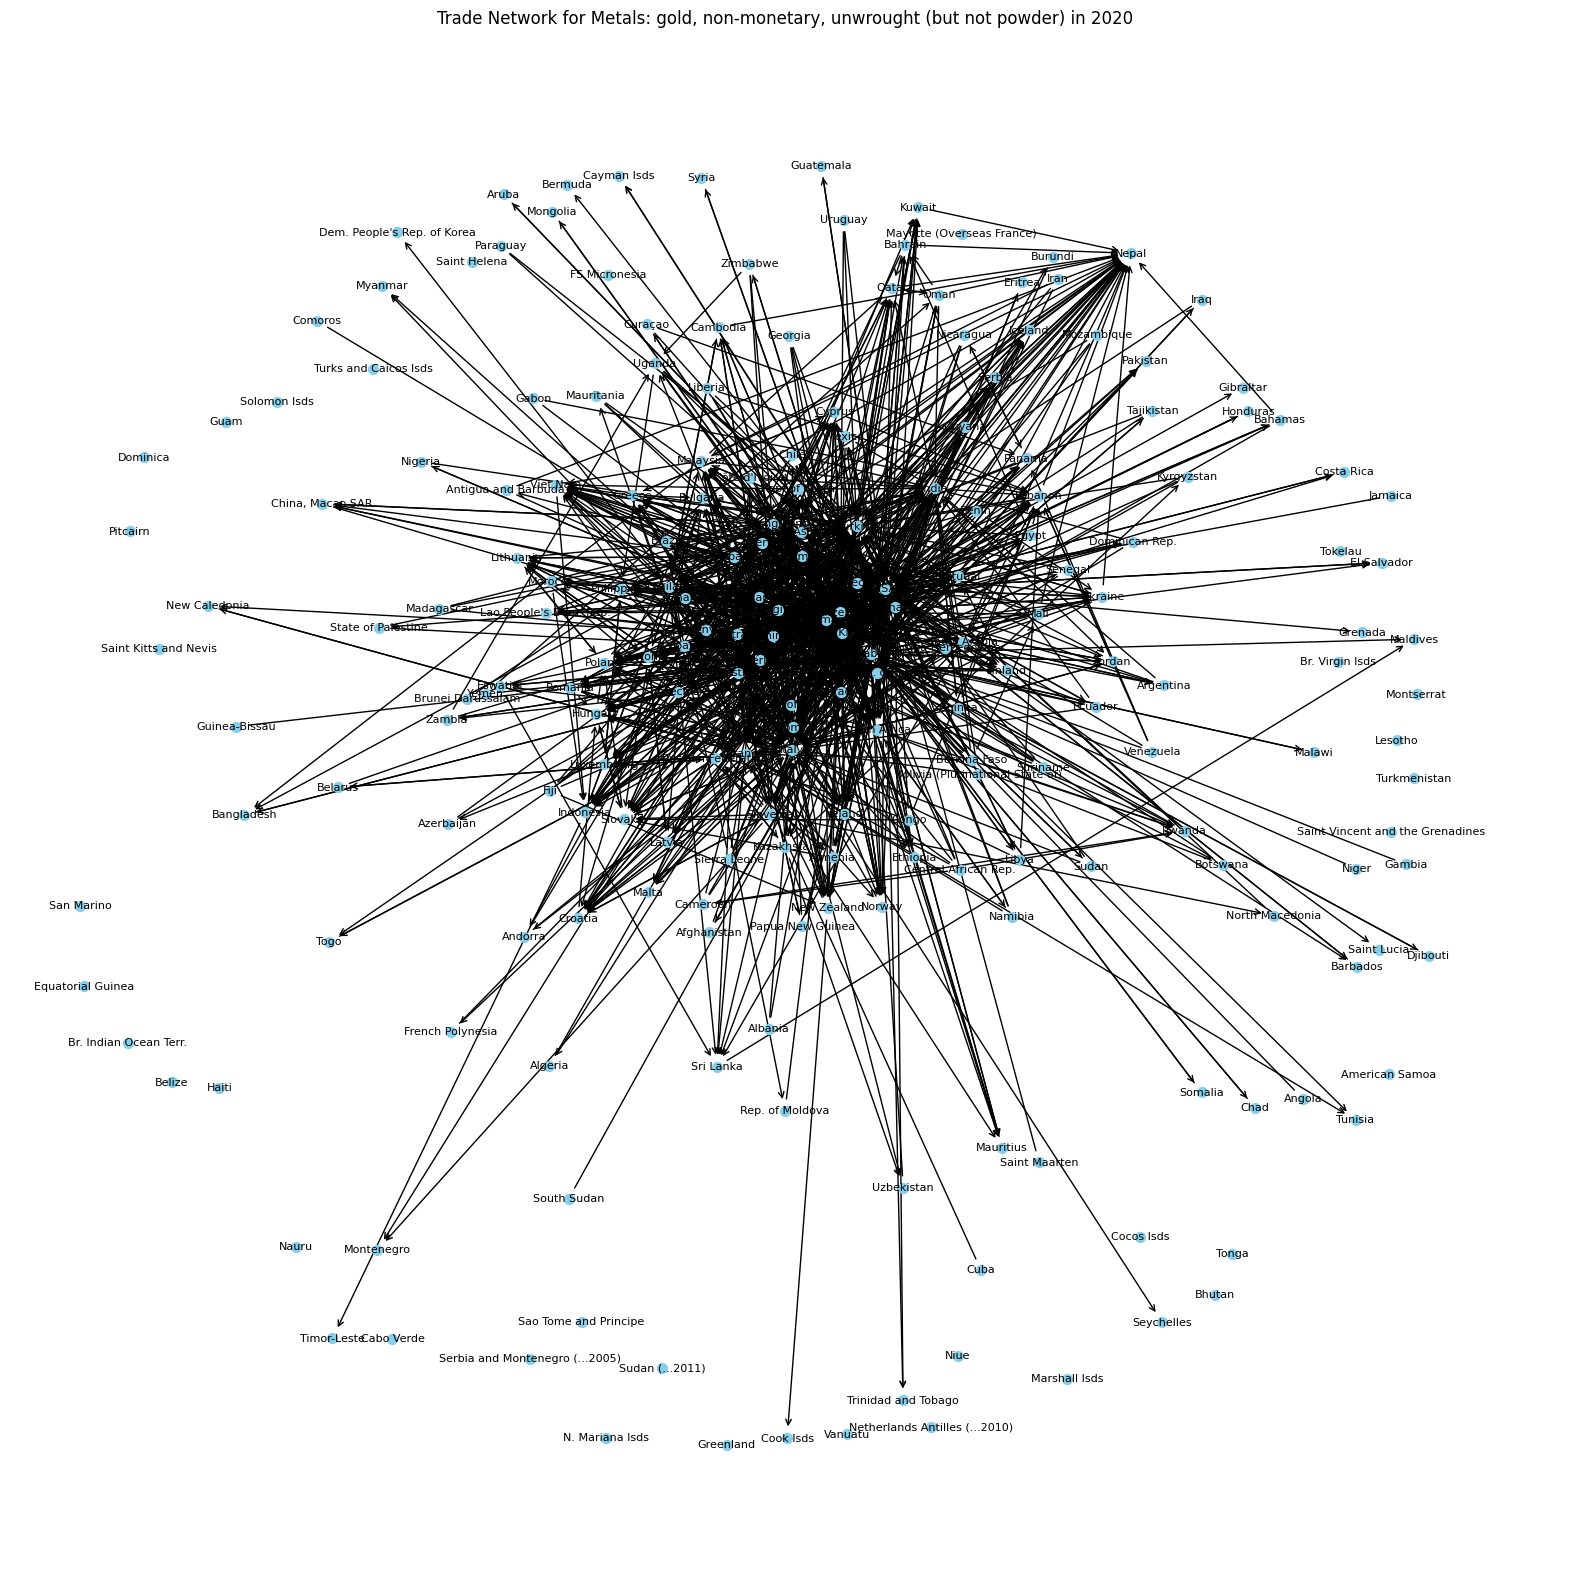

In [10]:
#####################
# WHOLE GRAPH
#####################
product_code_to_visualize = 710812
year_to_visualize = 2020
visualizer.visualize_product_graph(product_code_to_visualize, year_to_visualize)

C:\Users\sandr\AppData\Local\Temp\ipykernel_11180\2249288541.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


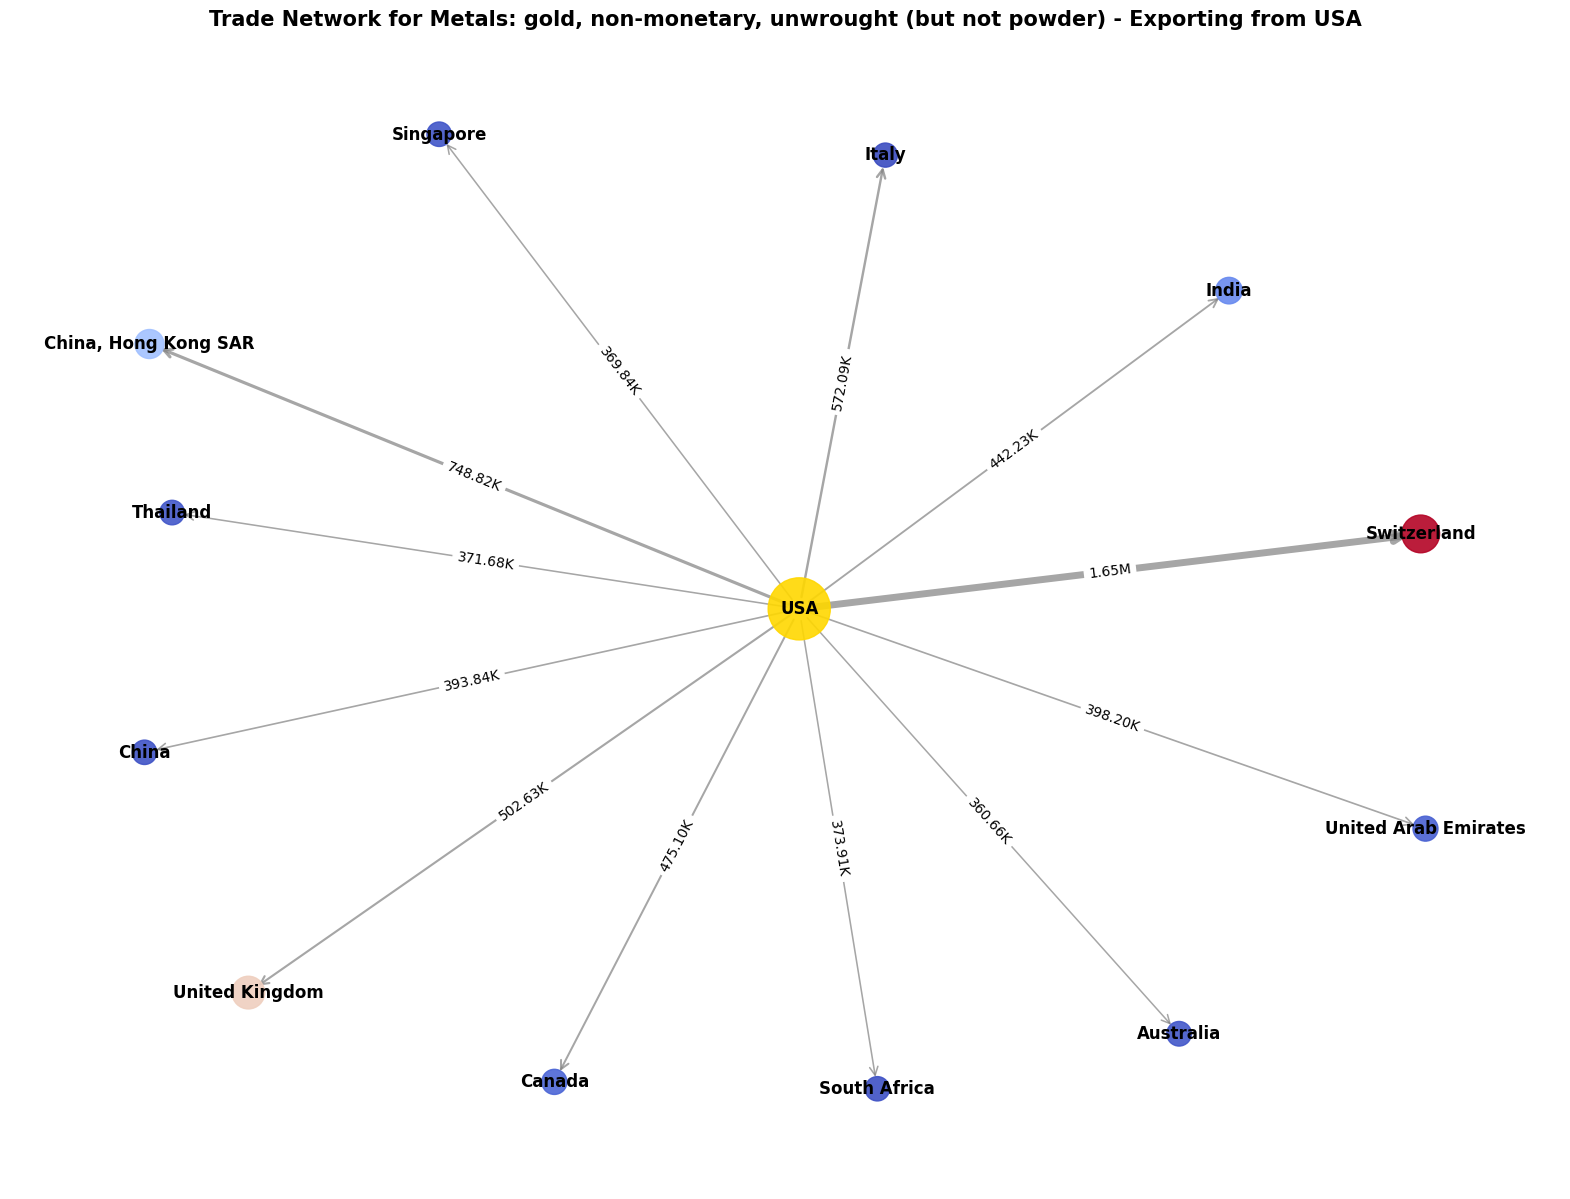

In [11]:
#####################
# SNAPSHOT OF GRAPH
#####################
product_code = 710812
country_name = 'USA'
trade_type = 'export'
visualizer.plot_trade_network(product_code, country_name, trade_type, percentile=0.95)

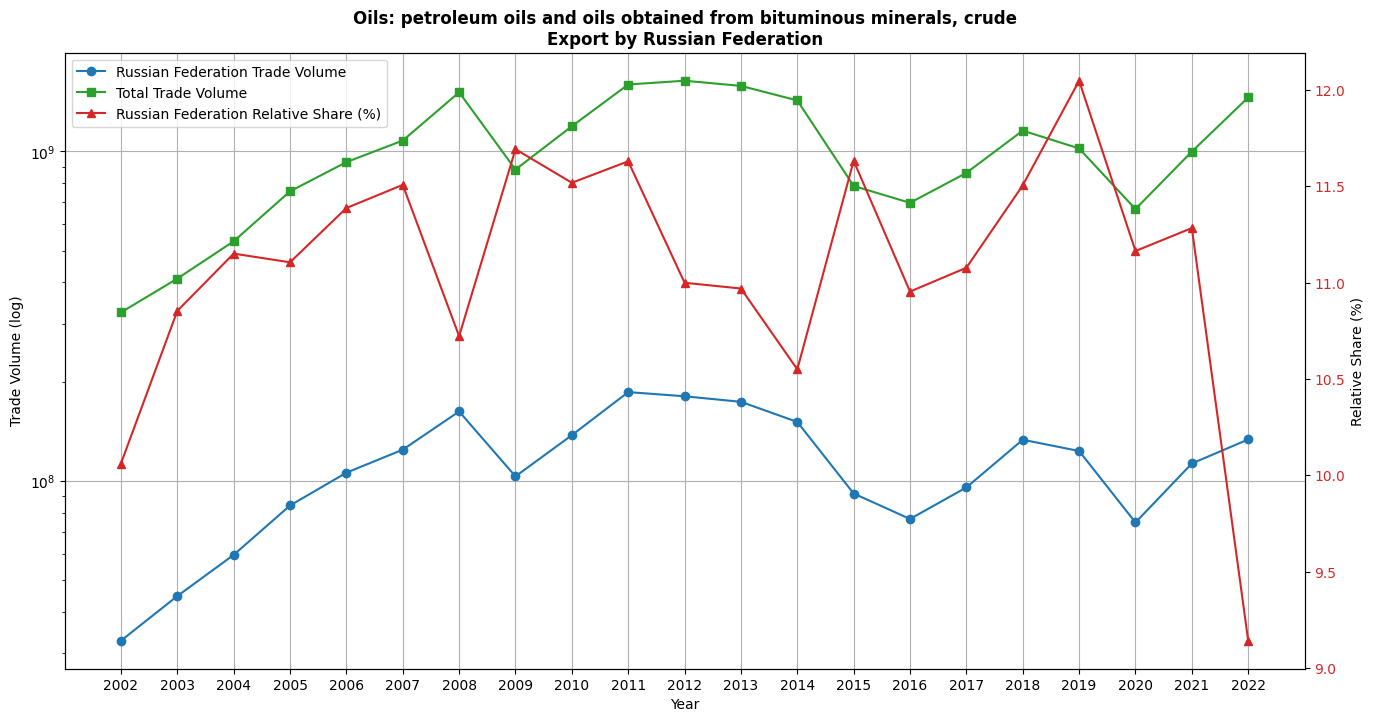

In [12]:
#####################
# TREND OVER TIME
#####################
product_code = 270900
trade_type = "export"
visualizer.plot_trade_over_time(product_code, "Russian Federation", trade_type)

In [13]:
#####################
# DASHBOARD
#####################

product_code = 710812
year_to_visualize = 2022
visualizer.plot_trade_treemap(product_code=product_code, year = year_to_visualize, trade_type='export')